In [1]:
# %pip install matplotlib pandas numpy wordcloud seaborn

### Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from pathlib import Path
import os
from wordcloud import WordCloud, STOPWORDS
import json
import collections
import datetime
from scipy import stats

### Loading Dataset

In [3]:
data = pd.read_csv('../Data/Data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   post_id                        217 non-null    int64  
 1   text                           217 non-null    object 
 2   post_text                      217 non-null    object 
 3   shared_text                    2 non-null      object 
 4   original_text                  18 non-null     object 
 5   time                           217 non-null    object 
 6   timestamp                      217 non-null    int64  
 7   image                          202 non-null    object 
 8   image_lowquality               216 non-null    object 
 9   images                         217 non-null    object 
 10  images_description             217 non-null    object 
 11  images_lowquality              217 non-null    object 
 12  images_lowquality_description  217 non-null    obj

### Data Cleaning

In [5]:
post_df = pd.DataFrame(data)
post_df.columns

Index(['post_id', 'text', 'post_text', 'shared_text', 'original_text', 'time',
       'timestamp', 'image', 'image_lowquality', 'images',
       'images_description', 'images_lowquality',
       'images_lowquality_description', 'video', 'video_duration_seconds',
       'video_height', 'video_id', 'video_quality', 'video_size_MB',
       'video_thumbnail', 'video_watches', 'video_width', 'likes', 'comments',
       'shares', 'post_url', 'link', 'links', 'user_id', 'username',
       'user_url', 'is_live', 'factcheck', 'shared_post_id', 'shared_time',
       'shared_user_id', 'shared_username', 'shared_post_url', 'available',
       'comments_full', 'reactors', 'w3_fb_url', 'reactions', 'reaction_count',
       'with', 'page_id', 'sharers', 'image_id', 'image_ids', 'was_live',
       'fetched_time'],
      dtype='object')

In [6]:
post_df.shape

(217, 51)

In [7]:
post_df.isnull().sum()

post_id                            0
text                               0
post_text                          0
shared_text                      215
original_text                    199
time                               0
timestamp                          0
image                             15
image_lowquality                   1
images                             0
images_description                 0
images_lowquality                  0
images_lowquality_description      0
video                            210
video_duration_seconds           217
video_height                     217
video_id                         210
video_quality                    217
video_size_MB                    217
video_thumbnail                  210
video_watches                    217
video_width                      217
likes                              0
comments                           0
shares                             0
post_url                           0
link                             215
l

In [8]:
# Loại bỏ các cột không cần thiết cho việc phân tích dữ liệu
post_df = post_df.drop(['shared_text', 'original_text', 'image', 
       'image_lowquality', 'images', 'images_description', 'images_lowquality',
       'images_lowquality_description', 'video', 'video_duration_seconds',
       'video_height', 'video_id', 'video_quality', 'video_size_MB',
       'video_thumbnail', 'video_watches', 'video_width', 'post_url', 'user_id', 'link', 'links', 
       'username', 'user_url', 'is_live', 'factcheck', 'shared_post_id', 
       'shared_time', 'shared_user_id', 'shared_username', 'shared_post_url', 
       'available', 'reactors', 'w3_fb_url', 'with', 'page_id', 'sharers', 'image_id', 
       'image_ids', 'was_live', 'fetched_time'], axis='columns')

In [9]:
post_df.columns

Index(['post_id', 'text', 'post_text', 'time', 'timestamp', 'likes',
       'comments', 'shares', 'comments_full', 'reactions', 'reaction_count'],
      dtype='object')

In [10]:
post_df.isnull().sum()

post_id            0
text               0
post_text          0
time               0
timestamp          0
likes              0
comments           0
shares             0
comments_full      0
reactions         43
reaction_count     0
dtype: int64

In [11]:
# Có một số hàng khi lấy dữ liệu về bị thiếu nên ta cần loại bỏ các hàng đó
post_df = post_df.dropna()
post_df.isnull().sum()

post_id           0
text              0
post_text         0
time              0
timestamp         0
likes             0
comments          0
shares            0
comments_full     0
reactions         0
reaction_count    0
dtype: int64

In [12]:
post_df.shape

(174, 11)

In [13]:
# Chuyển dữ liệu sang file để nhìn cho trực quan hơn
path = '../Data/dataset.csv'
post_df.to_csv(path, index=False)

In [14]:
data = pd.read_csv('../Data/dataset.csv')
post_df = pd.DataFrame(data)

In [15]:
post_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   post_id         174 non-null    int64 
 1   text            174 non-null    object
 2   post_text       174 non-null    object
 3   time            174 non-null    object
 4   timestamp       174 non-null    int64 
 5   likes           174 non-null    int64 
 6   comments        174 non-null    int64 
 7   shares          174 non-null    int64 
 8   comments_full   174 non-null    object
 9   reactions       174 non-null    object
 10  reaction_count  174 non-null    int64 
dtypes: int64(6), object(5)
memory usage: 15.1+ KB


In [16]:
post_df.shape

(174, 11)

### Data Preprocessing

In [17]:
post_reaction = post_df
post_reaction['reactions'] = post_reaction['reactions'].apply(lambda x : dict(eval(str(x))))
full_reactions = post_reaction['reactions'].apply(pd.Series)
post_full_reactions = pd.concat([post_reaction, full_reactions], axis=1).drop('reactions', axis=1)
post_full_reactions[['post_text', 'like', 'love', 'haha', 'wow', 'sad', 'angry', 'care', 'shares', 'comments','reaction_count']]

,post_text,like,love,haha,wow,sad,angry,care,shares,comments,reaction_count
0,Lennin với chúng tôi =))\r\n\r\nLennin is with...,764.0,4.0,294.0,1.0,3.0,NaN,2.0,2,15,1068
1,Ác thiệt mấy ní ơi 🥹,2016.0,26.0,222.0,2.0,5.0,NaN,1.0,3,113,2272
2,Anh tôi chụp ảnh đẹp quả cũng khổ 🤣\r\n\r\nMy ...,4803.0,43.0,3243.0,3.0,25.0,NaN,3.0,6,37,8120
3,Khét =)),1937.0,24.0,897.0,1.0,11.0,NaN,4.0,4,25,2874
4,Đừng để vụ này chìm!\r\n#Lazada1111 #Livestrea...,4035.0,17.0,29.0,1.0,2.0,NaN,NaN,102,21,4084
...,...,...,...,...,...,...,...,...,...,...,...
169,Rap Việt nơi bắt đầu và kết thúc 🥹,52238.0,1604.0,1485.0,129.0,19189.0,18.0,122.0,166,1000,74785
170,Rap Kiều lên sóng rồi bà coan ơi. Vô coi Kiều ...,3729.0,2.0,3.0,2.0,NaN,NaN,1.0,107,50,3737
171,"Phương Mỹ Chi phát hành chính thức album ""Vũ t...",2952.0,6.0,NaN,NaN,NaN,NaN,NaN,141,26,2958
172,Lại thêm một sadboiz 🥹,56210.0,1286.0,694.0,128.0,15182.0,8.0,116.0,207,1400,73624


In [18]:
for i in range(post_df.shape[0]):
    if pd.isna(post_full_reactions['like'].values[i]):
        post_full_reactions['like'].values[i] = 0
    if pd.isna(post_full_reactions['love'].values[i]):
        post_full_reactions['love'].values[i] = 0
    if pd.isna(post_full_reactions['haha'].values[i]):
        post_full_reactions['haha'].values[i] = 0
    if pd.isna(post_full_reactions['wow'].values[i]):
        post_full_reactions['wow'].values[i] = 0
    if pd.isna(post_full_reactions['sad'].values[i]):
        post_full_reactions['sad'].values[i] = 0
    if pd.isna(post_full_reactions['angry'].values[i]):
        post_full_reactions['angry'].values[i] = 0
    if pd.isna(post_full_reactions['care'].values[i]):
        post_full_reactions['care'].values[i] = 0
        
        
post_full_reactions[['post_text', 'like', 'love', 'haha', 'wow', 'sad', 'angry', 'care', 'shares', 'comments','reaction_count']]


,post_text,like,love,haha,wow,sad,angry,care,shares,comments,reaction_count
0,Lennin với chúng tôi =))\r\n\r\nLennin is with...,764.0,4.0,294.0,1.0,3.0,0.0,2.0,2,15,1068
1,Ác thiệt mấy ní ơi 🥹,2016.0,26.0,222.0,2.0,5.0,0.0,1.0,3,113,2272
2,Anh tôi chụp ảnh đẹp quả cũng khổ 🤣\r\n\r\nMy ...,4803.0,43.0,3243.0,3.0,25.0,0.0,3.0,6,37,8120
3,Khét =)),1937.0,24.0,897.0,1.0,11.0,0.0,4.0,4,25,2874
4,Đừng để vụ này chìm!\r\n#Lazada1111 #Livestrea...,4035.0,17.0,29.0,1.0,2.0,0.0,0.0,102,21,4084
...,...,...,...,...,...,...,...,...,...,...,...
169,Rap Việt nơi bắt đầu và kết thúc 🥹,52238.0,1604.0,1485.0,129.0,19189.0,18.0,122.0,166,1000,74785
170,Rap Kiều lên sóng rồi bà coan ơi. Vô coi Kiều ...,3729.0,2.0,3.0,2.0,0.0,0.0,1.0,107,50,3737
171,"Phương Mỹ Chi phát hành chính thức album ""Vũ t...",2952.0,6.0,0.0,0.0,0.0,0.0,0.0,141,26,2958
172,Lại thêm một sadboiz 🥹,56210.0,1286.0,694.0,128.0,15182.0,8.0,116.0,207,1400,73624


### Đâu là bài viết có lượt tương tác lớn nhất

In [19]:
max_reaction = max(post_full_reactions['reaction_count'])
max_reaction

207645

In [20]:
post=pd.DataFrame()
for i in range(post_full_reactions.shape[0]):
    if post_full_reactions['reaction_count'][i] == max_reaction:
        post = post_full_reactions.loc[i]
        print(post[['post_text', 'time', 'comments', 'shares', 'reaction_count']])

post_text         Người Tày chất 🫶\r\n\r\nTay people are cool
time                                      2023-09-22 00:14:28
comments                                                 3500
shares                                                    276
reaction_count                                         207645
Name: 157, dtype: object


In [21]:
post[['post_text', 'time', 'comments', 'shares', 'reaction_count', 'like', 'love', 'haha', 'wow', 'care', 'sad', 'angry']]

post_text         Người Tày chất 🫶\r\n\r\nTay people are cool
time                                      2023-09-22 00:14:28
comments                                                 3500
shares                                                    276
reaction_count                                         207645
like                                                 125125.0
love                                                  28198.0
haha                                                  52244.0
wow                                                     714.0
care                                                   1226.0
sad                                                     135.0
angry                                                     3.0
Name: 157, dtype: object

<Axes: >

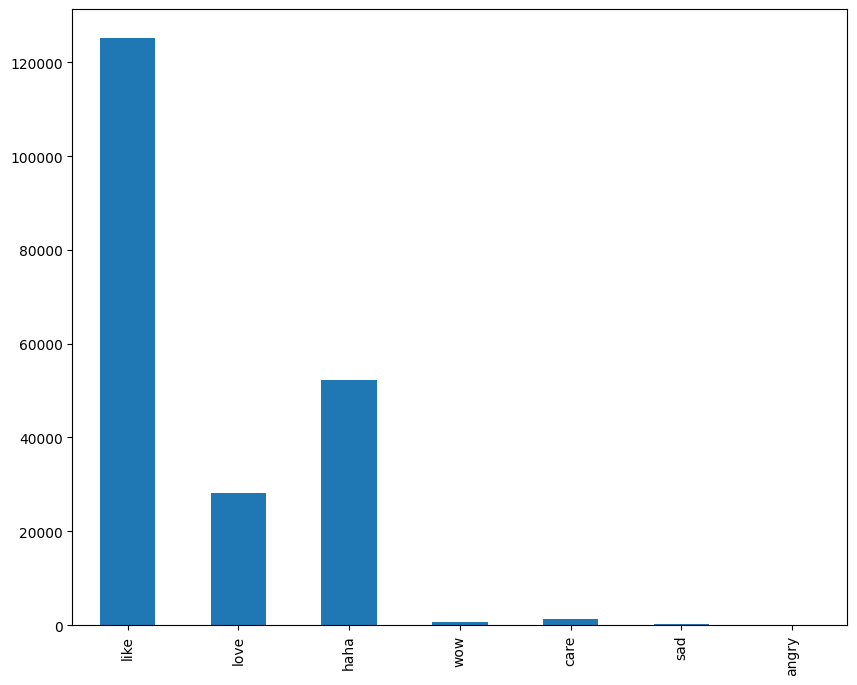

In [22]:
post[['like', 'love', 'haha', 'wow', 'care', 'sad', 'angry']].plot(kind='bar',figsize=(10,8))

### Số lượt tương tác của các bài đăng thay đổi như thế nào?

Text(0, 0.5, 'reaction_count')

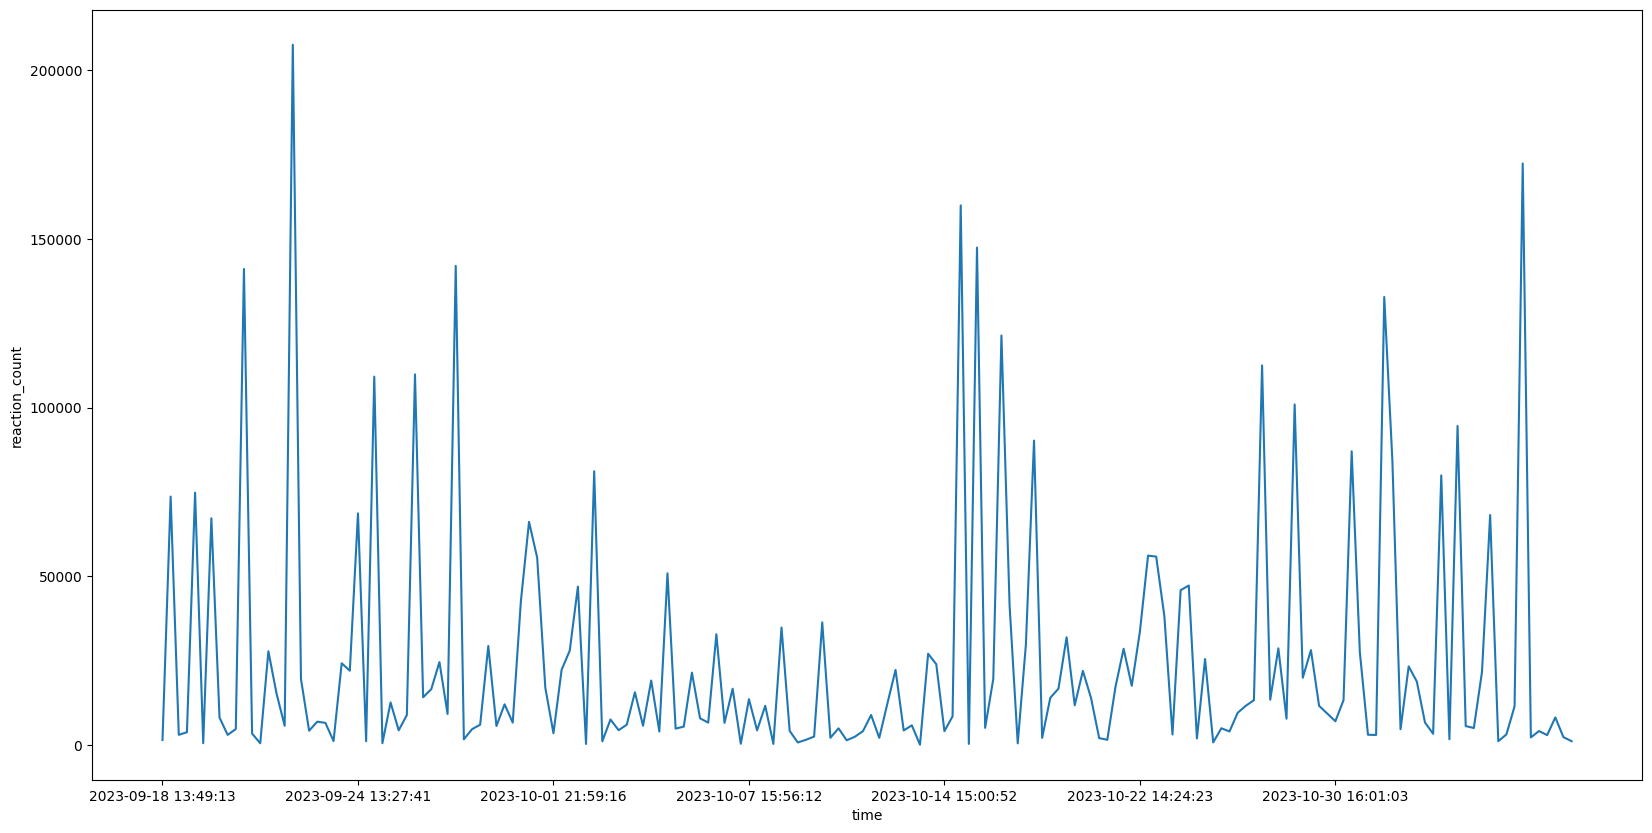

In [23]:
post_reactions_count = post_df[['time', 'reaction_count']]

x = post_reactions_count['time'].to_list()
y = post_reactions_count['reaction_count'].to_list()
x.reverse(), y.reverse()

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x, y)
ax.set_xticks(np.arange(0, 24 * 7, 24))
ax.set_xlabel('time')
ax.set_ylabel('reaction_count')

<Axes: >

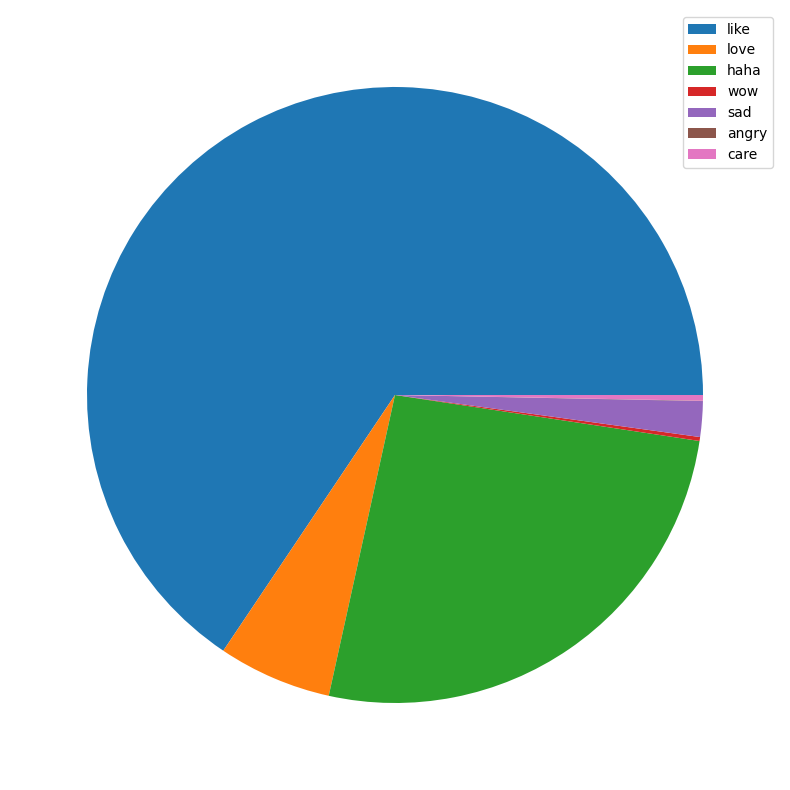

In [24]:
x = post_full_reactions[['like', 'love', 'haha', 'wow', 'sad', 'angry', 'care']].sum(axis=0)
x.plot(kind='pie', labels=None ,figsize=(10,10), legend=True)

Text(0, 0.5, 'Lượt tương tác')

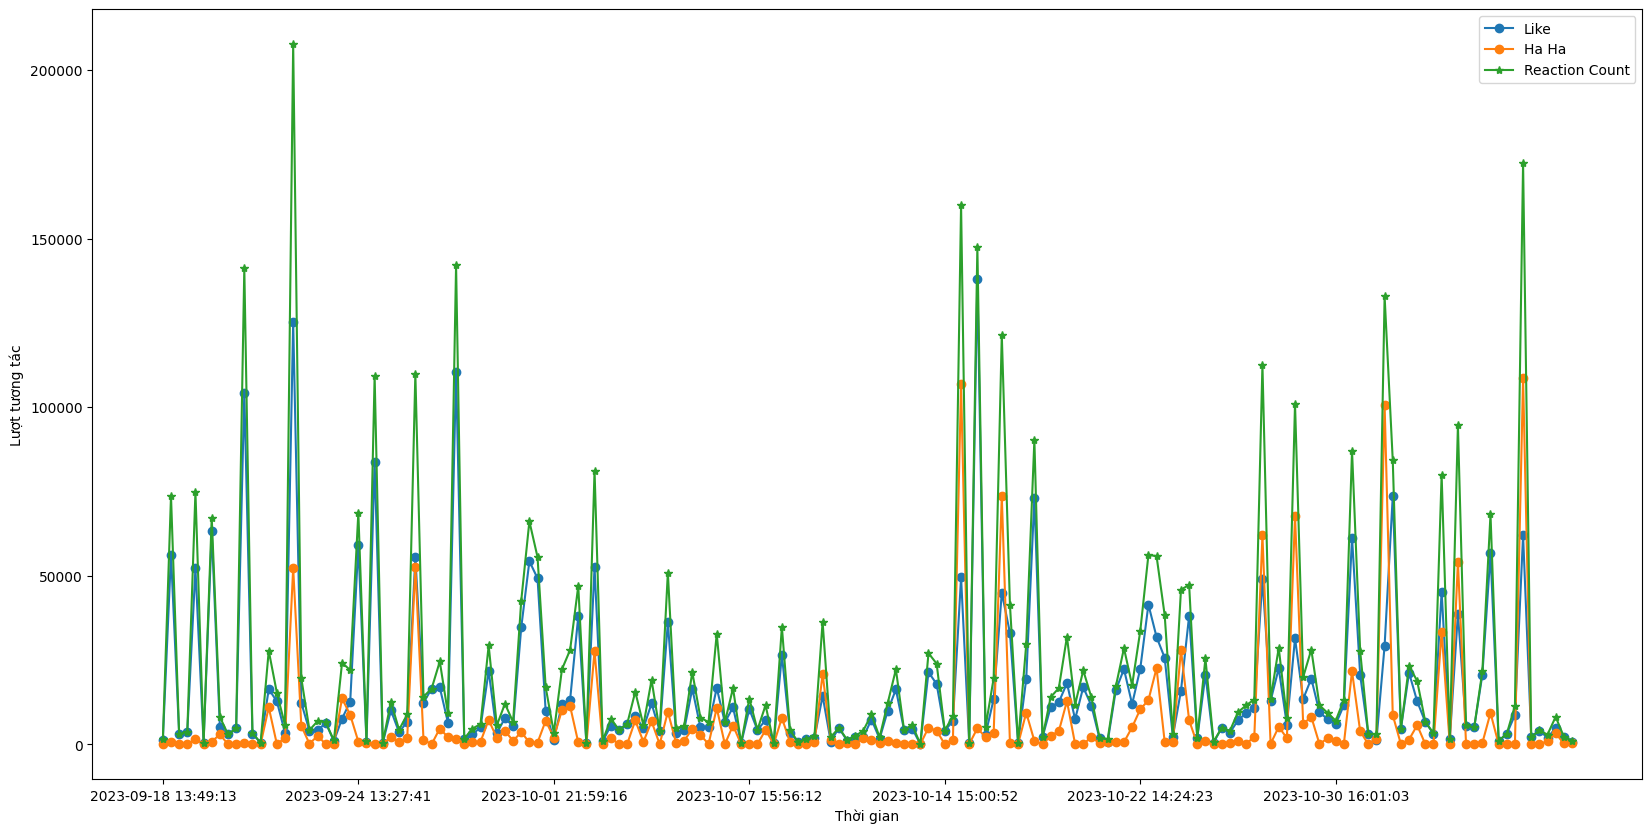

In [25]:
time = post_full_reactions['time'].to_list()
like = post_full_reactions['like'].to_list()
love = post_full_reactions['love'].to_list()
haha = post_full_reactions['haha'].to_list()
wow = post_full_reactions['wow'].to_list()
sad = post_full_reactions['sad'].to_list()
angry = post_full_reactions['angry'].to_list()
care = post_full_reactions['care'].to_list()
share = post_full_reactions['shares'].to_list()
comments = post_full_reactions['comments'].to_list()
reactions_count = post_full_reactions['reaction_count'].to_list()
time.reverse(), like.reverse(), haha.reverse(), wow.reverse(), sad.reverse(), angry.reverse(), care.reverse(), share.reverse(), comments.reverse(), reactions_count.reverse()

fig, ax = plt.subplots(figsize=(20,10))
# fig = plt.figure(figsize=(20, 10))
# ax = fig.add_subplot()
ax.plot(time, like, label = 'Like', marker='o')
# ax.plot(time, love, label = 'Love', marker='o')
ax.plot(time, haha, label = 'Ha Ha', marker='o')
# ax.plot(time, wow, label = 'Wow', marker='o')
# ax.plot(time, sad, label = 'Sad', marker='o')
# ax.plot(time, angry, label = 'Angry', marker='o')
# ax.plot(time, care, label = 'Care', marker='o')
# ax.plot(time, share, label = 'Shares')
# ax.plot(time, comments, label = 'Comments')
ax.plot(time, reactions_count, label = 'Reaction Count', marker='*')
ax.set_xticks(np.arange(0, 24 * 7, 24))
plt.legend()
ax.set_xlabel('Thời gian')
ax.set_ylabel('Lượt tương tác')

### Sự tương quan giữa số lượng reactions với các trường khác như số lượng bình luận, số lượt chia sẻ, …?

In [26]:
text = []
for i in post_full_reactions['post_text']:
    i = str(i).replace('\n\n', ' ')
    i = str(i).replace('\n', ' ')
    text.append(str(i).split(' '))
    
count = []
for i in text:
    count.append(len(i))
# count = np.column_stack((np.arange(len(count)), count))
count = pd.DataFrame(count)
count.columns = ['a']

<function matplotlib.pyplot.show(close=None, block=None)>

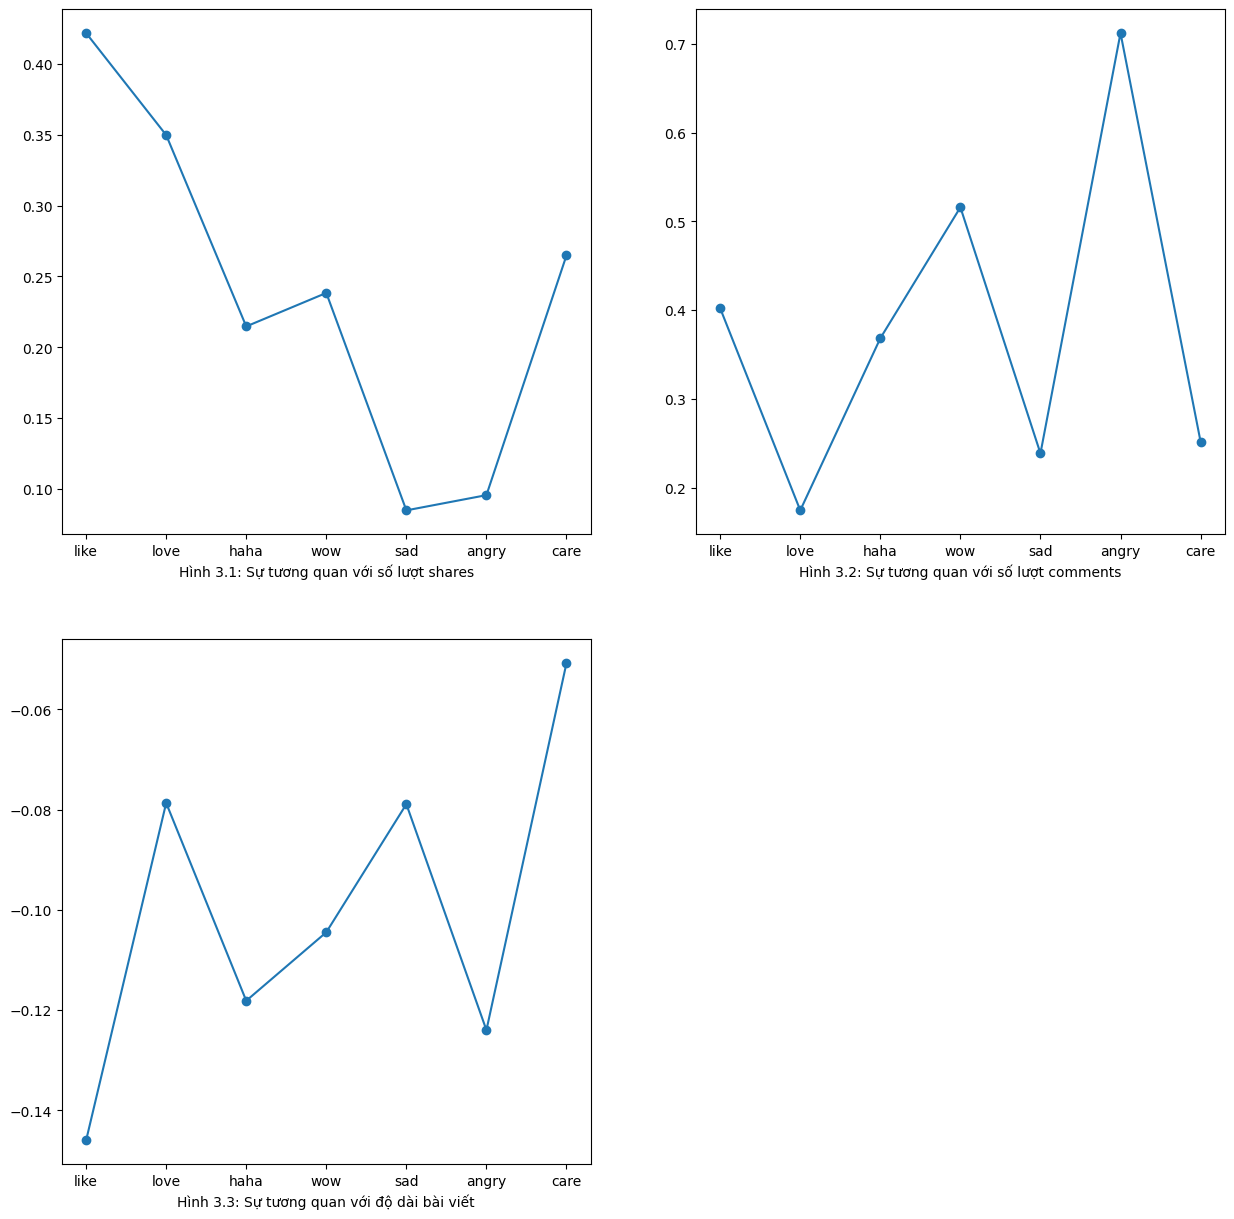

In [27]:
x=post_full_reactions[['like', 'love', 'haha', 'wow', 'sad', 'angry', 'care']].corrwith(post_full_reactions['shares'])
y=post_full_reactions[['like', 'love', 'haha', 'wow', 'sad', 'angry', 'care']].corrwith(post_full_reactions['comments'])
z=post_full_reactions[['like', 'love', 'haha', 'wow', 'sad', 'angry', 'care']].corrwith(count['a'])

fig = plt.figure(figsize=(15,15))
a1 = fig.add_subplot(2,2,1)
plt.plot(x, marker = 'o')
plt.xlabel('Hình 3.1: Sự tương quan với số lượt shares')

a2 = fig.add_subplot(2,2,2)
plt.plot(y, marker = 'o')
plt.xlabel('Hình 3.2: Sự tương quan với số lượt comments')

a3 = fig.add_subplot(2,2,3)
plt.plot(z, marker = 'o')
plt.xlabel('Hình 3.3: Sự tương quan với độ dài bài viết')

plt.show

In [28]:
print(x)
print(y)
print(z)

like     0.421613
love     0.349704
haha     0.214734
wow      0.238349
sad      0.085008
angry    0.095740
care     0.264832
dtype: float64
like     0.402020
love     0.174490
haha     0.368316
wow      0.515836
sad      0.238648
angry    0.712040
care     0.251864
dtype: float64
like    -0.146003
love    -0.078665
haha    -0.118143
wow     -0.104469
sad     -0.078902
angry   -0.123999
care    -0.050748
dtype: float64


### Đâu là thời gian Fanpage thường đăng bài, một ngày Fanpage đăng tối đa bao nhiêu bài đăng, trung bình một ngày đăng bao nhiêu bài?

In [29]:
time_with_reactionCount = post_df[['time','reaction_count']]
tgian_dangbai = []
for time in time_with_reactionCount['time']:
    s = time[11:]
    # print(s)
    s = datetime.time(int(s[:2]),int(s[3:5]),int(s[6:]))
    hour = s.hour
    minute = s.minute
    second = s.second
    if second > 30:
        minute+=1
        second=0
    else:
        second=0
    
    if minute==60:
        minute=0
        hour+=1
    t = datetime.time(hour, minute, second)
    tgian_dangbai.append(t)

In [30]:
khoang_tgian = ['0h00-0h30','0h30-1h00','1h00-1h30','1h30-2h00','2h00-2h30','2h30-3h00',
                '3h00-3h30','3h30-4h00','4h00-4h30','4h30-5h00','5h00-5h30','5h30-6h00',
                '6h00-6h30','6h30-7h00','7h00-7h30','7h30-8h00','8h00-8h30','8h30-9h00',
                '9h00-9h30','9h30-10h00','10h00-10h30','10h30-11h00','11h00-11h30','11h30-12h00',
                '12h00-12h30','12h30-13h00','13h00-13h30','13h30-14h00','14h00-14h30','14h30-15h00',
                '15h00-15h30','15h30-16h00','16h00-16h30','16h30-17h00','17h00-17h30','17h30-18h00',
                '18h00-18h30','18h30-19h00','19h00-19h30','19h30-20h00','20h00-20h30','20h30-21h00',
                '21h00-21h30','21h30-22h00','22h00-22h30','22h30-23h00','23h00-23h30','23h30-0h00']

tgian = {}
so_reaction = {}
df = []
for i in range(len(tgian_dangbai)):
    h = tgian_dangbai[i].hour
    m = tgian_dangbai[i].minute
    if m<30:
        if khoang_tgian[2*h] in tgian:
            tgian[khoang_tgian[2*h]]+=1
            so_reaction[khoang_tgian[2*h]]+=time_with_reactionCount['reaction_count'][i]
        else:
            tgian[khoang_tgian[2*h]]=1            
            so_reaction[khoang_tgian[2*h]]=time_with_reactionCount['reaction_count'][i]
    elif m>=30:
        if khoang_tgian[2*h+1] in tgian:
            tgian[khoang_tgian[2*h+1]]+=1
            so_reaction[khoang_tgian[2*h+1]]+=time_with_reactionCount['reaction_count'][i]
        else:
            tgian[khoang_tgian[2*h+1]]=1 
            so_reaction[khoang_tgian[2*h+1]]=time_with_reactionCount['reaction_count'][i]
for i in khoang_tgian:
    if i not in tgian:
        tgian[i]=0
        so_reaction[i]=0
df.append(tgian)
df.append(so_reaction)
df = pd.DataFrame(df)
df = df.loc[:, khoang_tgian]
df

,0h00-0h30,0h30-1h00,1h00-1h30,1h30-2h00,2h00-2h30,2h30-3h00,3h00-3h30,3h30-4h00,4h00-4h30,4h30-5h00,...,19h00-19h30,19h30-20h00,20h00-20h30,20h30-21h00,21h00-21h30,21h30-22h00,22h00-22h30,22h30-23h00,23h00-23h30,23h30-0h00
0,2,1,0,0,0,0,0,0,0,0,...,7,10,10,10,4,10,10,7,3,5
1,239542,24542,0,0,0,0,0,0,0,0,...,40635,270193,83183,81600,305916,83185,319332,242509,46903,42650


In [31]:
thoi_gian = df.loc[0,:][df.loc[0,:]>0]

<Axes: xlabel='Thời gian', ylabel='Số bài đăng'>

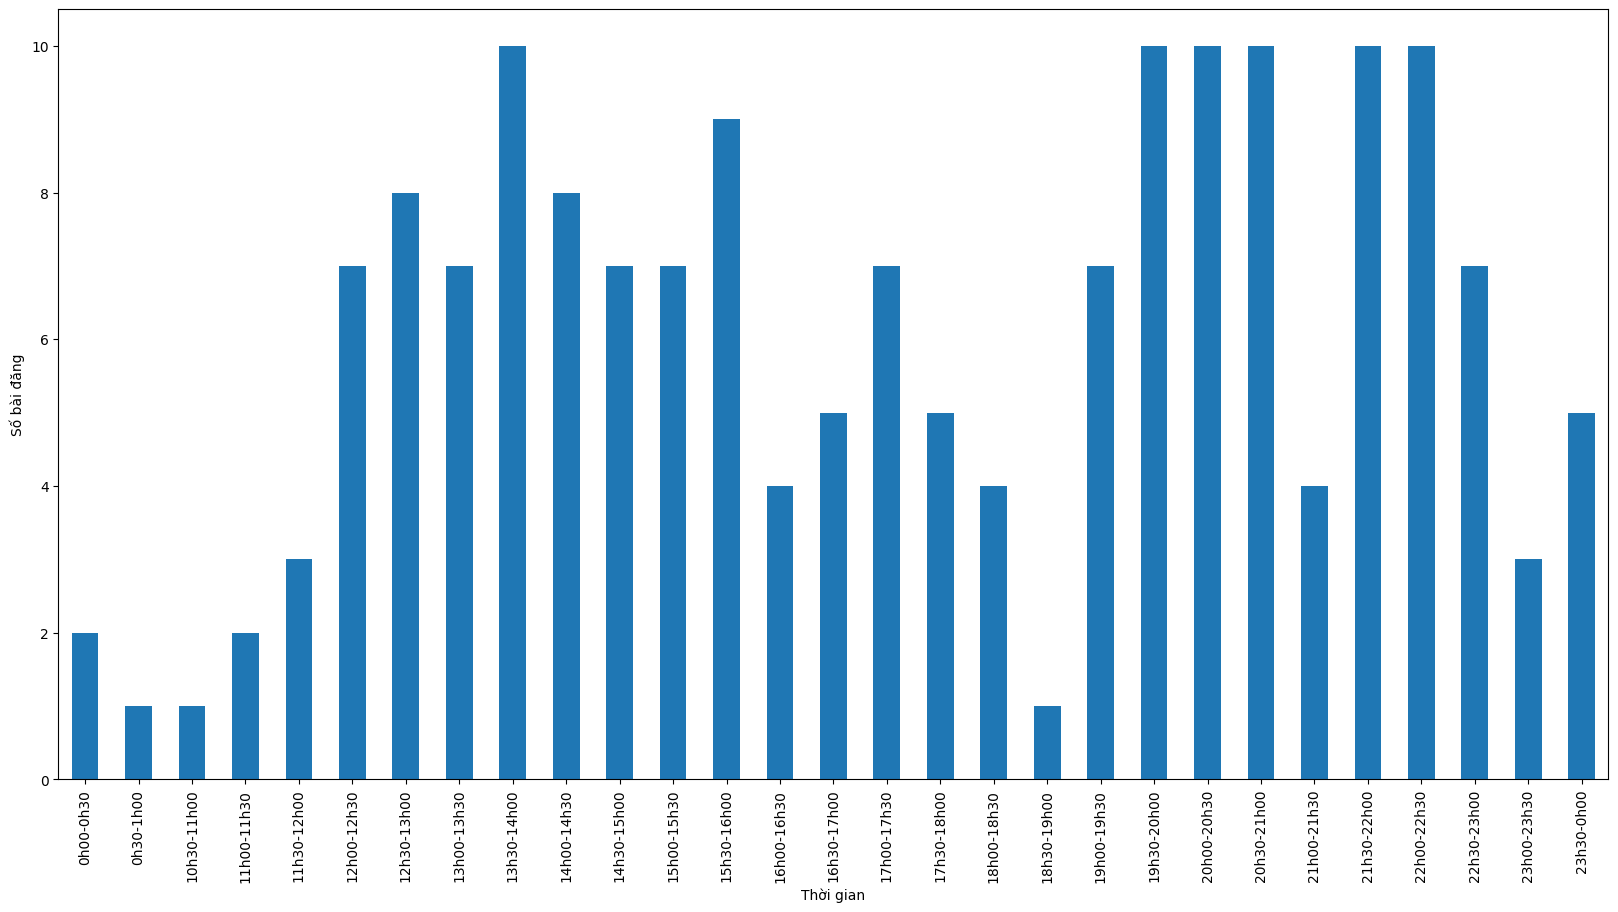

In [32]:
thoi_gian = df.loc[0,:][df.loc[0,:]>0]
thoi_gian.plot(kind='bar', figsize=(20,10), xlabel='Thời gian', ylabel='Số bài đăng')

In [33]:
k = max(thoi_gian)
b = thoi_gian[thoi_gian==k]
print('Thời gian hay đăng bài trong ngày:',b.index[::])

Thời gian hay đăng bài trong ngày: Index(['13h30-14h00', '19h30-20h00', '20h00-20h30', '20h30-21h00',
       '21h30-22h00', '22h00-22h30'],
      dtype='object')


<function matplotlib.pyplot.show(close=None, block=None)>

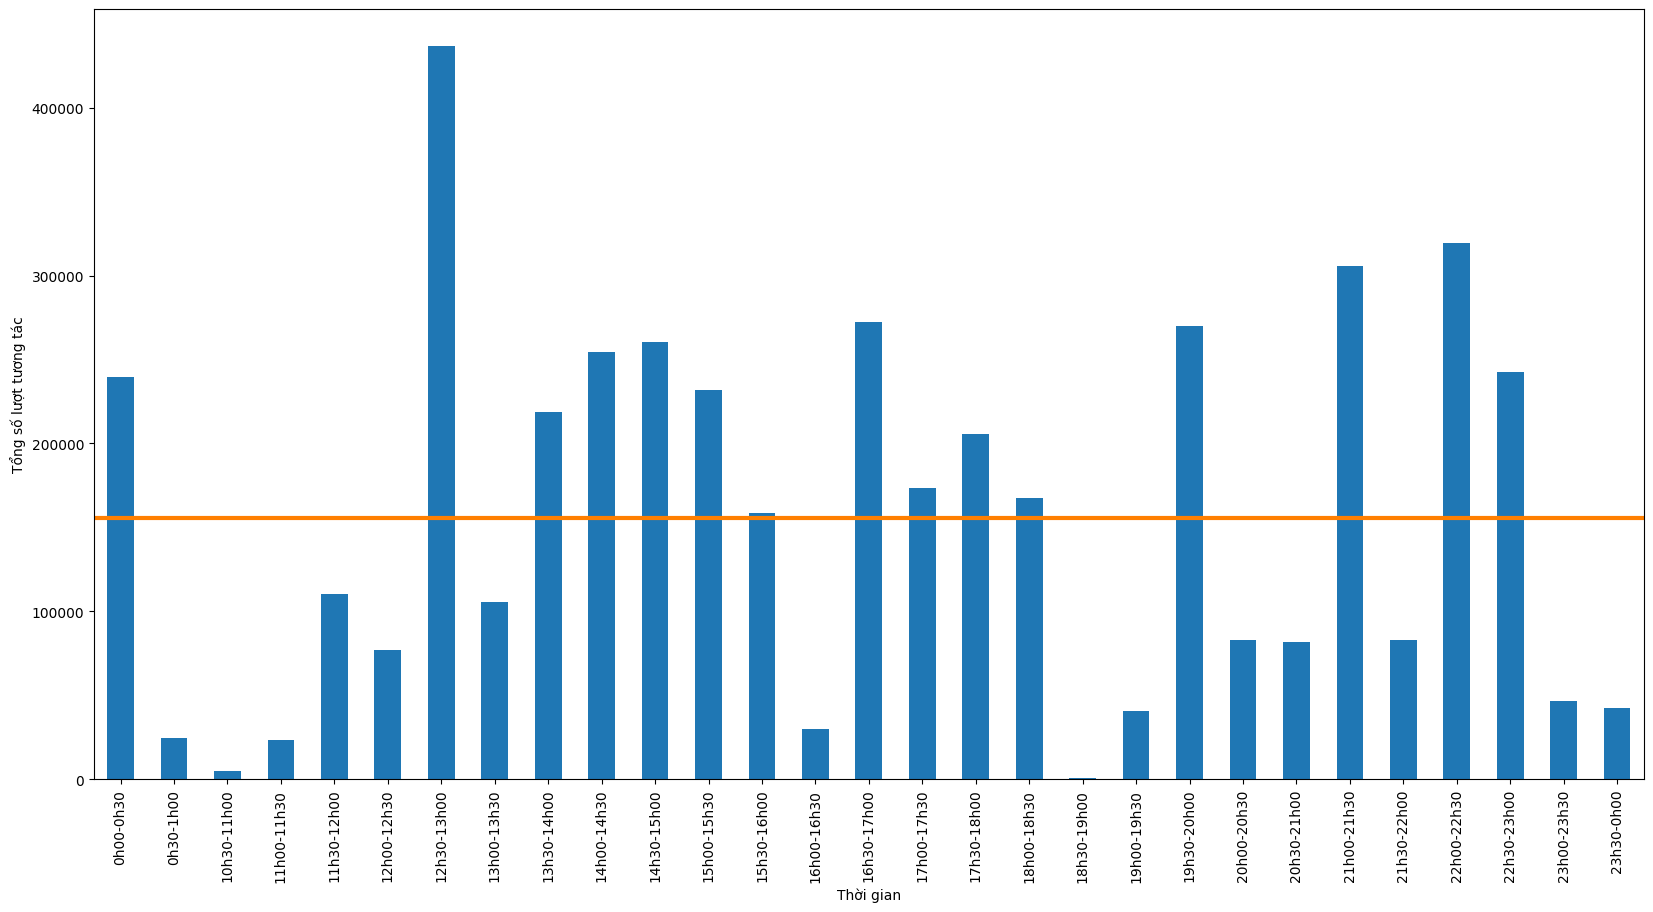

In [34]:
# Đăng bài trong khoảng thời gian nào được nhiều lượt thích nhất
reactions = df.loc[1,:][df.loc[1,:]>0]
mean_reactions = reactions.mean()
plt.subplots(figsize=(20,10))
reactions.plot(kind='bar', figsize=(20,10), xlabel='Thời gian', ylabel='Tổng số lượt tương tác')
plt.plot([-1, 30], [mean_reactions, mean_reactions], color='#FF7F00', linewidth=3.0)
plt.show

In [35]:
k = max(reactions)
b = reactions[reactions==k]
print('Thời gian đăng bài có nhiều lượt tương tác:',b.index[::])

Thời gian đăng bài có nhiều lượt tương tác: Index(['12h30-13h00'], dtype='object')


In [36]:
b = reactions.mean()
b = reactions[reactions>=b]
print(b.index[::])

Index(['0h00-0h30', '12h30-13h00', '13h30-14h00', '14h00-14h30', '14h30-15h00',
       '15h00-15h30', '15h30-16h00', '16h30-17h00', '17h00-17h30',
       '17h30-18h00', '18h00-18h30', '19h30-20h00', '21h00-21h30',
       '22h00-22h30', '22h30-23h00'],
      dtype='object')


In [37]:
ngay = []
for time in time_with_reactionCount['time']:
    s = time[5:10]
    # print(s)
    ngay.append(s)
ngay = collections.Counter(ngay)
ngays = []
ngays.append(ngay)
ngays = pd.DataFrame(ngays)
a = ngays.loc[0].index[::]
b = a[::-1]
ngays = ngays.loc[:,b]
ngay = ngays.loc[0]
max_post = max(ngay)
print('Số lượng post lớn nhất đăng trong 1 ngày là:', max_post)
a = ngay.mean()
print('Trung bình một ngày đăng số lượng post là:',a)

Số lượng post lớn nhất đăng trong 1 ngày là: 8
Trung bình một ngày đăng số lượng post là: 3.5510204081632653


<Axes: xlabel='Ngày', ylabel='Số bài đăng'>

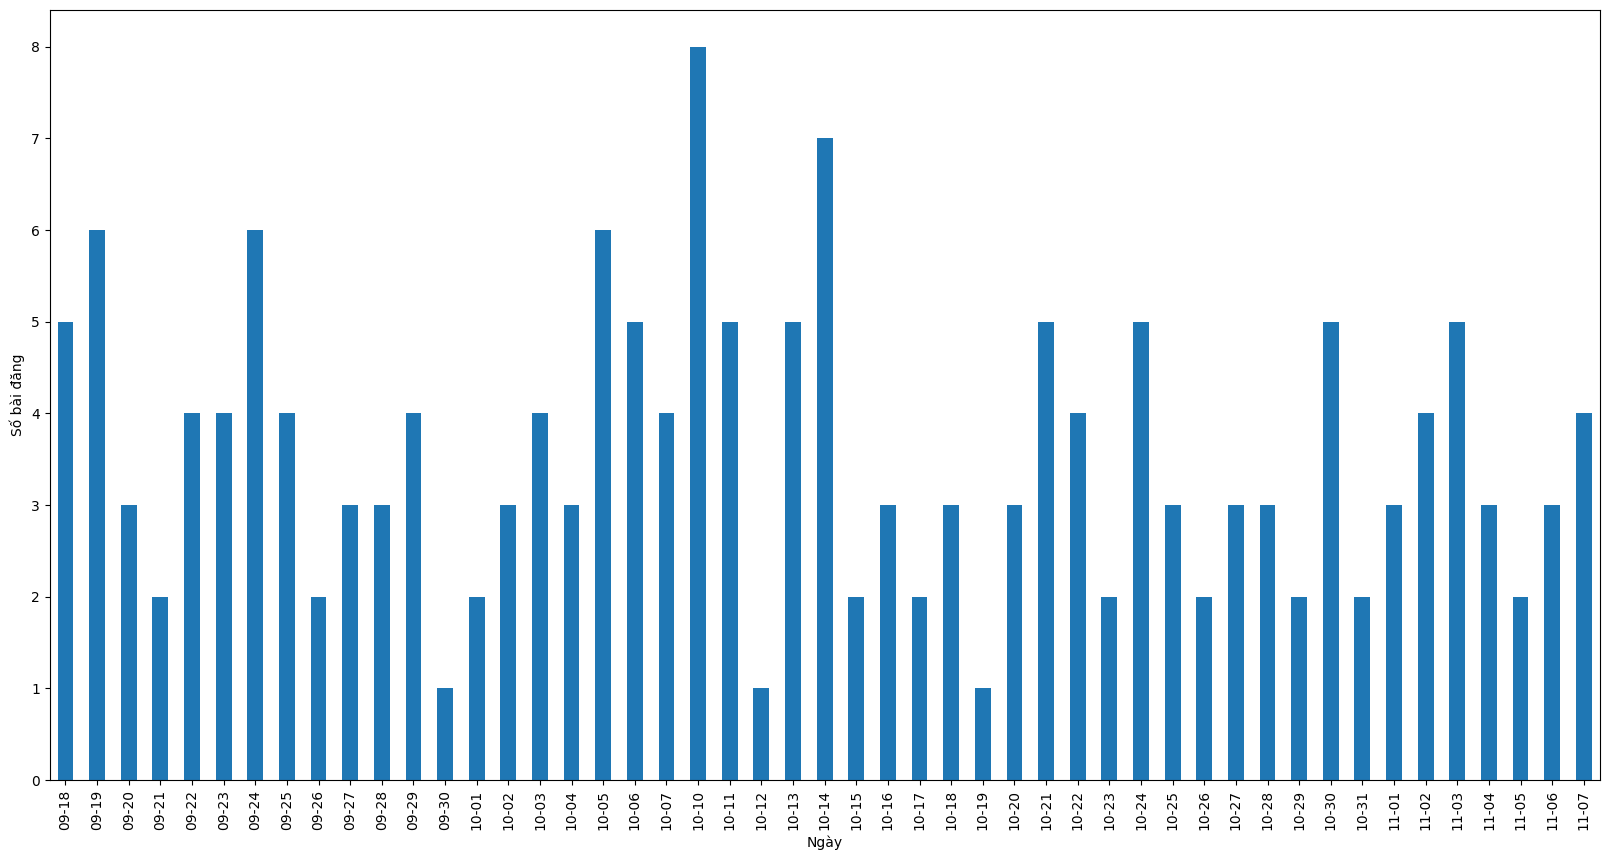

In [38]:
ngay.plot(kind='bar', figsize=(20,10), xlabel='Ngày', ylabel='Số bài đăng')

### Dự đoán

#### Dữ liệu sau 10 ngày

In [39]:
data_after = pd.read_csv("../Data/Data_After.csv")
# data_after.info()

In [40]:
post_df_after = pd.DataFrame(data_after)
post_df_after = post_df_after.drop(['shared_text', 'original_text', 'image', 
       'image_lowquality', 'images', 'images_description', 'images_lowquality',
       'images_lowquality_description', 'video', 'video_duration_seconds',
       'video_height', 'video_id', 'video_quality', 'video_size_MB',
       'video_thumbnail', 'video_watches', 'video_width', 'post_url', 'user_id', 'link', 'links', 
       'username', 'user_url', 'is_live', 'factcheck', 'shared_post_id', 
       'shared_time', 'shared_user_id', 'shared_username', 'shared_post_url', 
       'available', 'reactors', 'w3_fb_url', 'with', 'page_id', 'sharers', 'image_id', 
       'image_ids', 'was_live', 'fetched_time'], axis='columns')

In [41]:
post_df_after.isnull().sum()

post_id           0
text              0
post_text         0
time              0
timestamp         0
likes             0
comments          0
shares            0
comments_full     0
reactions         0
reaction_count    0
dtype: int64

In [42]:
post_reaction_after = post_df_after
post_reaction_after['reactions'] = post_reaction_after['reactions'].apply(lambda x : dict(eval(str(x))))
full_reactions_after = post_reaction_after['reactions'].apply(pd.Series)
post_full_reactions_after = pd.concat([post_reaction_after, full_reactions_after], axis=1).drop('reactions', axis=1)

In [43]:
for i in range(post_df_after.shape[0]):
    if pd.isna(post_full_reactions_after['like'].values[i]):
        post_full_reactions_after['like'].values[i] = 0
    if pd.isna(post_full_reactions_after['love'].values[i]):
        post_full_reactions_after['love'].values[i] = 0
    if pd.isna(post_full_reactions_after['haha'].values[i]):
        post_full_reactions_after['haha'].values[i] = 0
    if pd.isna(post_full_reactions_after['wow'].values[i]):
        post_full_reactions_after['wow'].values[i] = 0
    if pd.isna(post_full_reactions_after['sad'].values[i]):
        post_full_reactions_after['sad'].values[i] = 0
    if pd.isna(post_full_reactions_after['angry'].values[i]):
        post_full_reactions_after['angry'].values[i] = 0
    if pd.isna(post_full_reactions_after['care'].values[i]):
        post_full_reactions_after['care'].values[i] = 0

In [44]:
time_with_reactionCount_after = post_df_after[['time','reaction_count']]
tgian_dangbai_after = []
for time in time_with_reactionCount_after['time']:
    s = time[11:]
    # print(s)
    s = datetime.time(int(s[:2]),int(s[3:5]),int(s[6:]))
    hour = s.hour
    minute = s.minute
    second = s.second
    if second > 30:
        minute+=1
        second=0
    else:
        second=0
    
    if minute==60:
        minute=0
        hour+=1
    t = datetime.time(hour, minute, second)
    tgian_dangbai_after.append(t)

In [45]:
tgian_after = {}
so_reaction_after = {}
df_after = []
for i in range(len(tgian_dangbai_after)):
    h = tgian_dangbai_after[i].hour
    m = tgian_dangbai_after[i].minute
    if m<30:
        if khoang_tgian[2*h] in tgian_after:
            tgian_after[khoang_tgian[2*h]]+=1
            so_reaction_after[khoang_tgian[2*h]]+=time_with_reactionCount_after['reaction_count'][i]
        else:
            tgian_after[khoang_tgian[2*h]]=1            
            so_reaction_after[khoang_tgian[2*h]]=time_with_reactionCount_after['reaction_count'][i]
    elif m>=30:
        if khoang_tgian[2*h+1] in tgian_after:
            tgian_after[khoang_tgian[2*h+1]]+=1
            so_reaction_after[khoang_tgian[2*h+1]]+=time_with_reactionCount_after['reaction_count'][i]
        else:
            tgian_after[khoang_tgian[2*h+1]]=1 
            so_reaction_after[khoang_tgian[2*h+1]]=time_with_reactionCount_after['reaction_count'][i]
for i in khoang_tgian:
    if i not in tgian_after:
        tgian_after[i]=0
        so_reaction_after[i]=0
df_after.append(tgian_after)
df_after.append(so_reaction_after)
df_after = pd.DataFrame(df_after)
df_after = df_after.loc[:, khoang_tgian]
df_after

,0h00-0h30,0h30-1h00,1h00-1h30,1h30-2h00,2h00-2h30,2h30-3h00,3h00-3h30,3h30-4h00,4h00-4h30,4h30-5h00,...,19h00-19h30,19h30-20h00,20h00-20h30,20h30-21h00,21h00-21h30,21h30-22h00,22h00-22h30,22h30-23h00,23h00-23h30,23h30-0h00
0,0,0,0,0,0,0,0,0,0,0,...,1,3,2,3,3,1,1,1,0,3
1,0,0,0,0,0,0,0,0,0,0,...,1322,7932,3881,14888,34551,42967,2661,11741,0,6759


In [46]:
ngay_after = []
for time in time_with_reactionCount_after['time']:
    s = time[5:10]
    # print(s)
    ngay_after.append(s)
ngay_after = collections.Counter(ngay_after)
ngay_afters = []
ngay_afters.append(ngay_after)
ngay_afters = pd.DataFrame(ngay_afters)
a = ngay_afters.loc[0].index[::]
b = a[::-1]
ngay_afters = ngay_afters.loc[:,b]
ngay_after = ngay_afters.loc[0]

In [47]:
ngay_after

11-07    1
11-08    3
11-09    4
11-10    3
11-11    4
11-12    2
11-14    6
11-15    3
11-16    3
11-17    4
Name: 0, dtype: int64

#### So sánh

In [48]:
reac = post_full_reactions[['comments', 'shares', 'reaction_count', 'like', 'love', 'haha', 'wow', 'care', 'sad', 'angry']].mean(axis=0)
so_bai_viet = ngay
print("Số bài viết 1 ngày:",so_bai_viet.mean())
print(reac)

Số bài viết 1 ngày: 3.5510204081632653
comments            685.097701
shares               88.660920
reaction_count    25926.994253
like              17005.201149
love               1545.385057
haha               6757.597701
wow                  53.482759
care                 77.166667
sad                 483.925287
angry                 4.235632
dtype: float64


In [49]:
reac_after = post_full_reactions_after[['comments', 'shares', 'reaction_count', 'like', 'love', 'haha', 'wow', 'care', 'sad', 'angry']].mean(axis=0)
so_bai_viet_after = ngay_after
print("Số bài viết 1 ngày:",so_bai_viet_after.mean())
print(reac_after)

Số bài viết 1 ngày: 3.3
comments            263.696970
shares               40.303030
reaction_count    17723.363636
like              11641.363636
love                635.393939
haha               5317.696970
wow                  40.424242
care                 38.818182
sad                  47.363636
angry                 2.303030
dtype: float64


In [50]:
x = [270, 35, 10400, 6800, 600, 2700, 21, 31, 96, 1.5]
y = reac_after.tolist()
print("Số bài viết 1 ngày: {:.2f}%".format(so_bai_viet_after.mean()*100/so_bai_viet.mean()))
print("comments: {:.2f}%".format(y[0]*100/x[0]))
print("shares: {:.2f}%".format(y[1]*100/x[1]))
print("reaction_count: {:.2f}%".format(y[2]*100/x[2]))
print("like: {:.2f}%".format(y[3]*100/x[3]))
print("love: {:.2f}%".format(y[4]*100/x[4]))
print("haha: {:.2f}%".format(y[5]*100/x[5]))
print("wow: {:.2f}%".format(y[6]*100/x[6]))
print("care: {:.2f}%".format(y[7]*100/x[7]))
print("sad: {:.2f}%".format(y[8]*100/x[8]))
print("angry: {:.2f}%".format(y[9]*100/x[9]))


Số bài viết 1 ngày: 92.93%
comments: 97.67%
shares: 115.15%
reaction_count: 170.42%
like: 171.20%
love: 105.90%
haha: 196.95%
wow: 192.50%
care: 125.22%
sad: 49.34%
angry: 153.54%


### Đâu là từ khóa xuất hiện nhiều nhất trong các bài đăng đã thu thập hay đâu là từ khóa xuát hiện nhiều nhất trong các bình luận đã thu thập?

In [51]:
# Tìm các bài viết chứa 1 từ khóa nào đó
a = post_full_reactions['post_text'].tolist()
b = post_full_reactions_after['post_text'].tolist()
res = []
for x in a:
    if 'binz' in str(x).lower():
        res.append(x)
for x in b:
    if 'binz' in str(x).lower():
        res.append(x)
print('Số bài viết có từ "Binz":',len(res))
res

Số bài viết có từ "Binz": 5


["'Hit Me Up' chưa hạ nhiệt, Xuân Đan (Binz) tiếp tục cho ra mắt EP 'Đan Xinh In Love' hẳn 6 bài nhạc tình cho fan tha hồ tạo trend\r\n\r\nĐích thị là nhạc của người có tình iu!!!! Tình wa tìnhhhh",
 'Binz và Đen Vâu đổi phong cách cho nhau à 🤣',
 'Giao diện mới của chú Binz🤣',
 'Học trò của Binz tại Rap Việt - Kellie dạo gần đây 🥹',
 'Không phải Binz Bình Dương, đây mới là Đan Lê "xịn" xuất hiện, cùng anh em SS đi xem phim bom tấn Mỹ dùng nhạc Bigcityboi 🤣\r\n\r\n#WarnerMusicVietnam #Binz #Expend4bles #BigCityBoi #SpaceSpeakers']

In [52]:
# Lấy tất cả các bài viết
text = ''
for i in post_full_reactions['post_text']:
    text = text + str(i) + '\n'
for i in post_full_reactions_after['post_text']:
    text = text + str(i) + '\n'

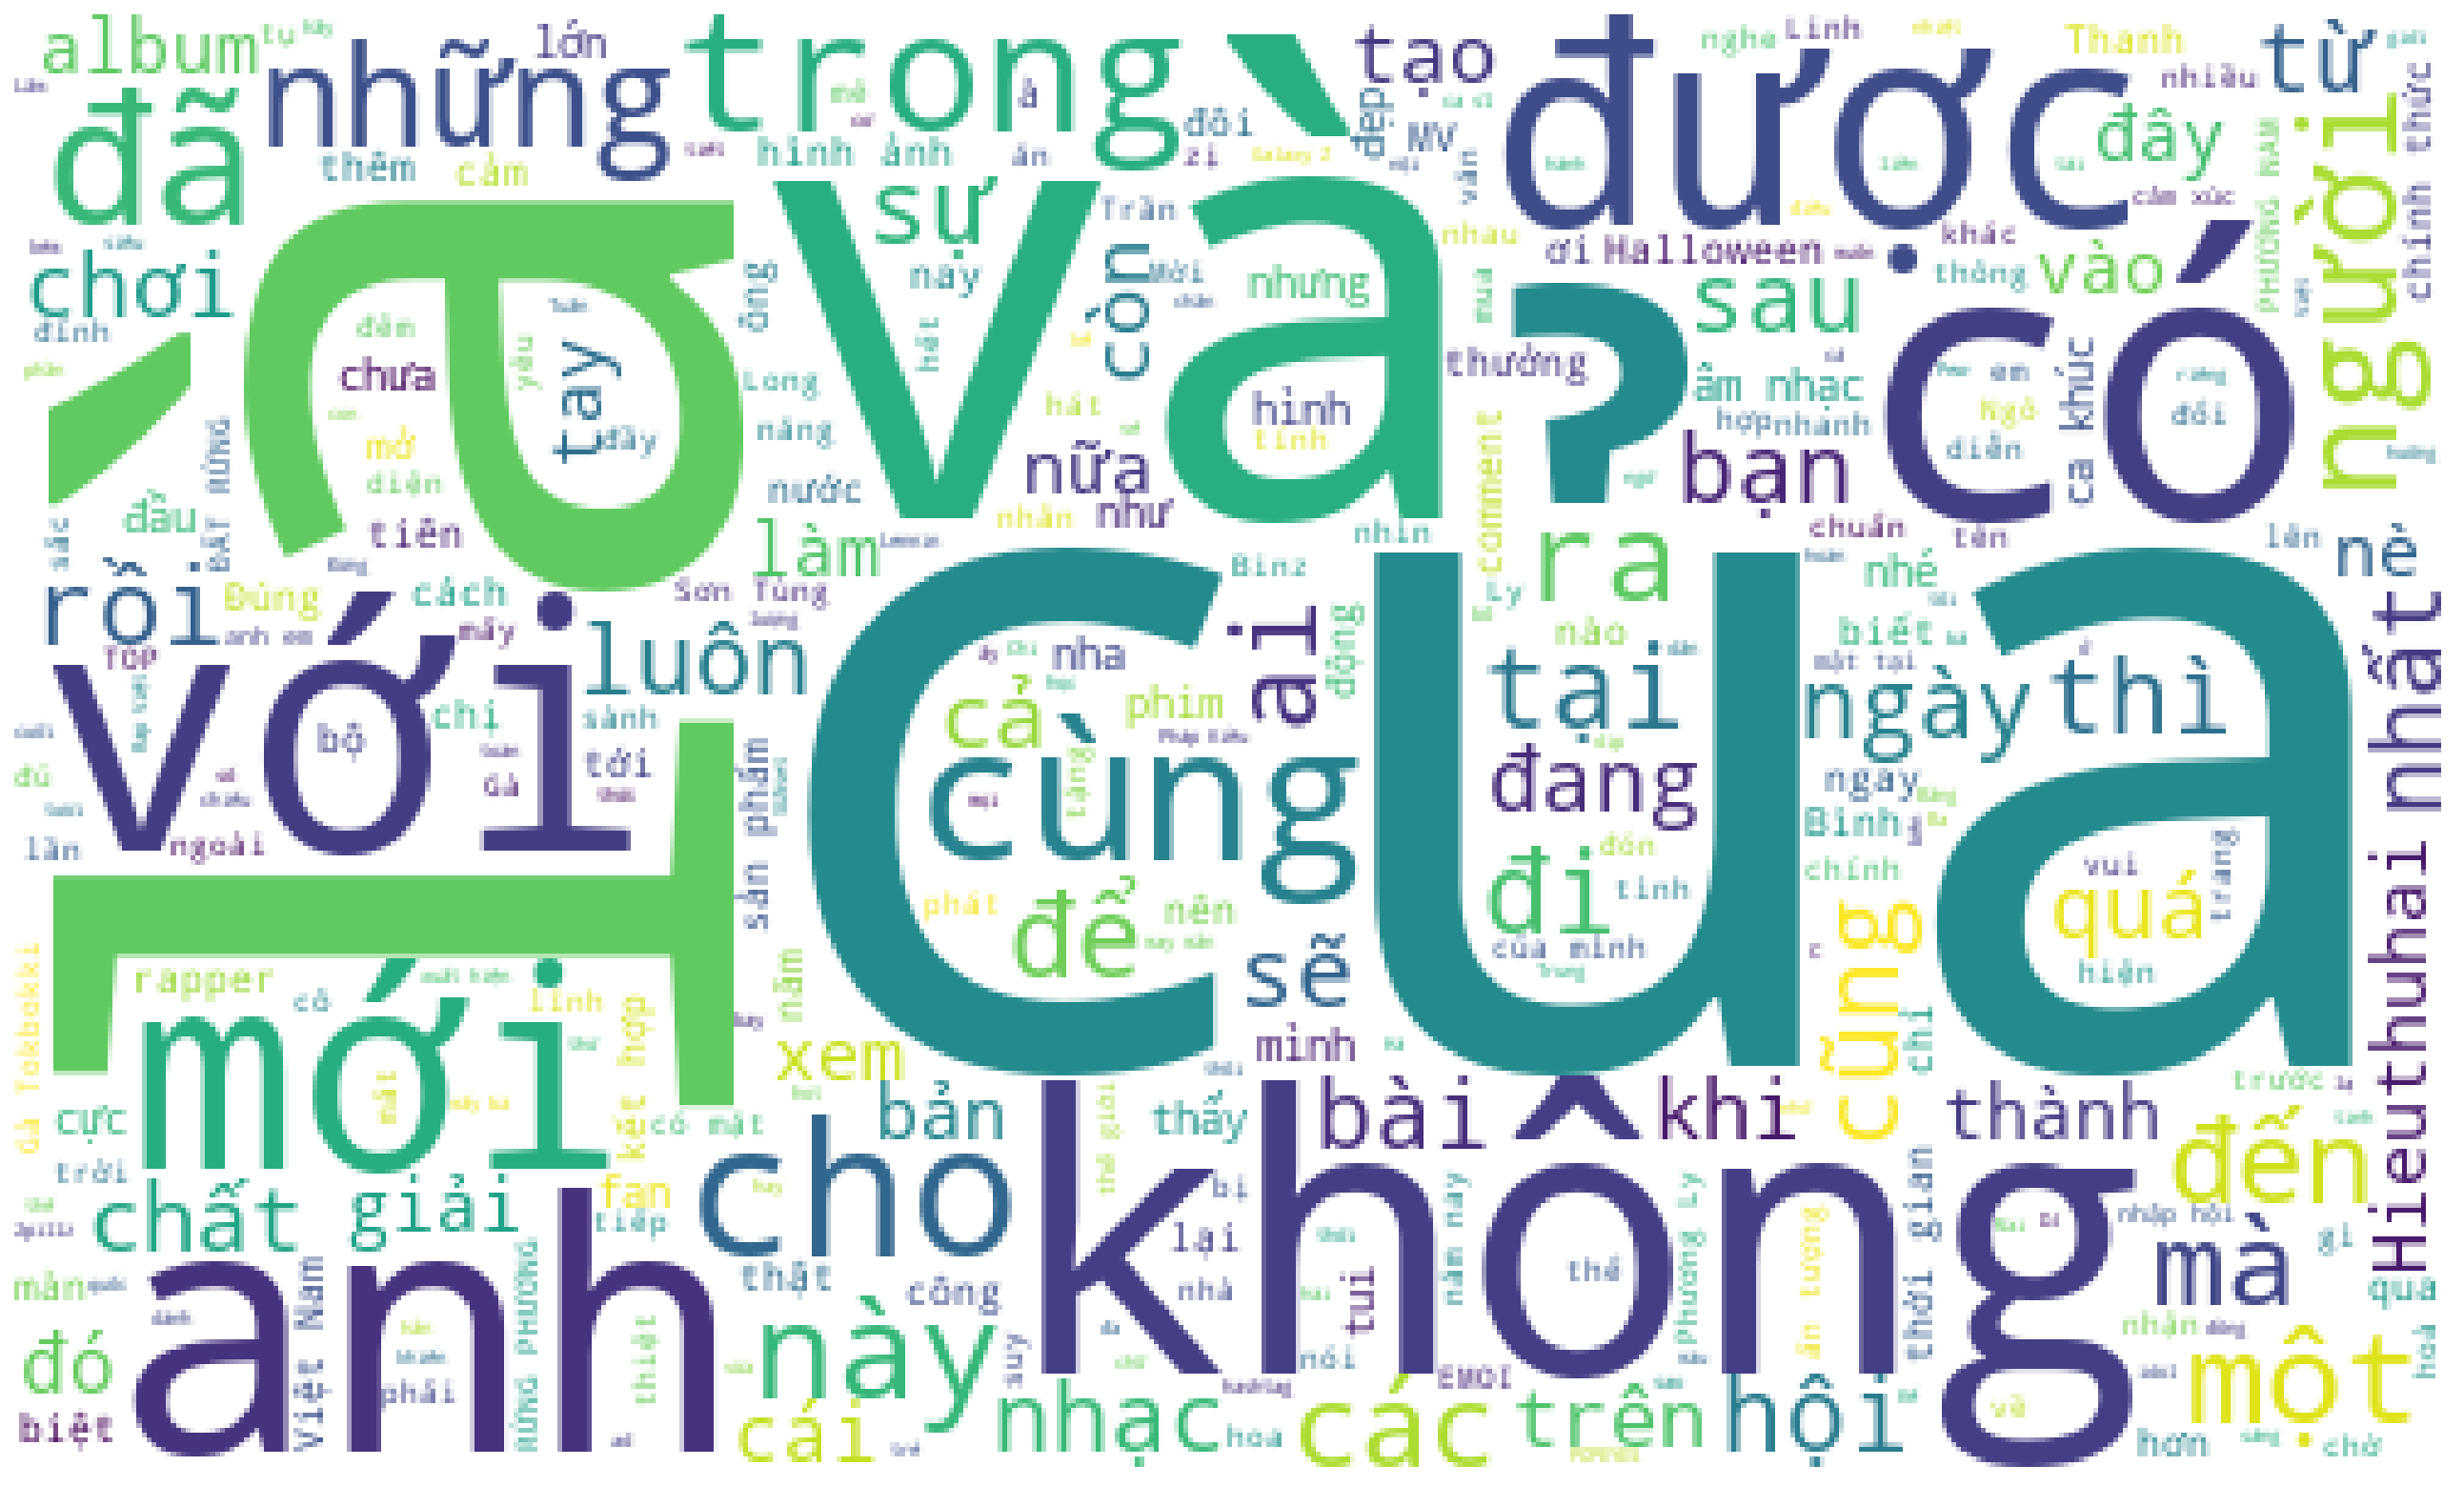

In [53]:
texto = text

wordcloud = WordCloud(stopwords=STOPWORDS, 
                      background_color='white',
                      max_words=300,
                      width=500, height=300).generate(texto)

plt.figure(figsize=(40, 20))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [54]:
post_list = np.load('../Data/Data.npy', allow_pickle=True)
post_list_after = np.load('../Data/Data_After.npy', allow_pickle=True)

In [55]:
res = []
for post in post_list:
    if len(post['comments_full']) > 0:
        # print(post['comments_full'])
        cmt = '\n'.join([comment['comment_text'] for comment in post['comments_full']])
        res.append(cmt)
for post in post_list_after:
    if len(post['comments_full']) > 0:
        # print(post['comments_full'])
        cmt = '\n'.join([comment['comment_text'] for comment in post['comments_full']])
        res.append(cmt)
print('\nSố bài viết có comments:', len(res))
# print(res)


Số bài viết có comments: 215


In [56]:
comment = ''
for i in res:
    comment = comment + str(i) + '\n'

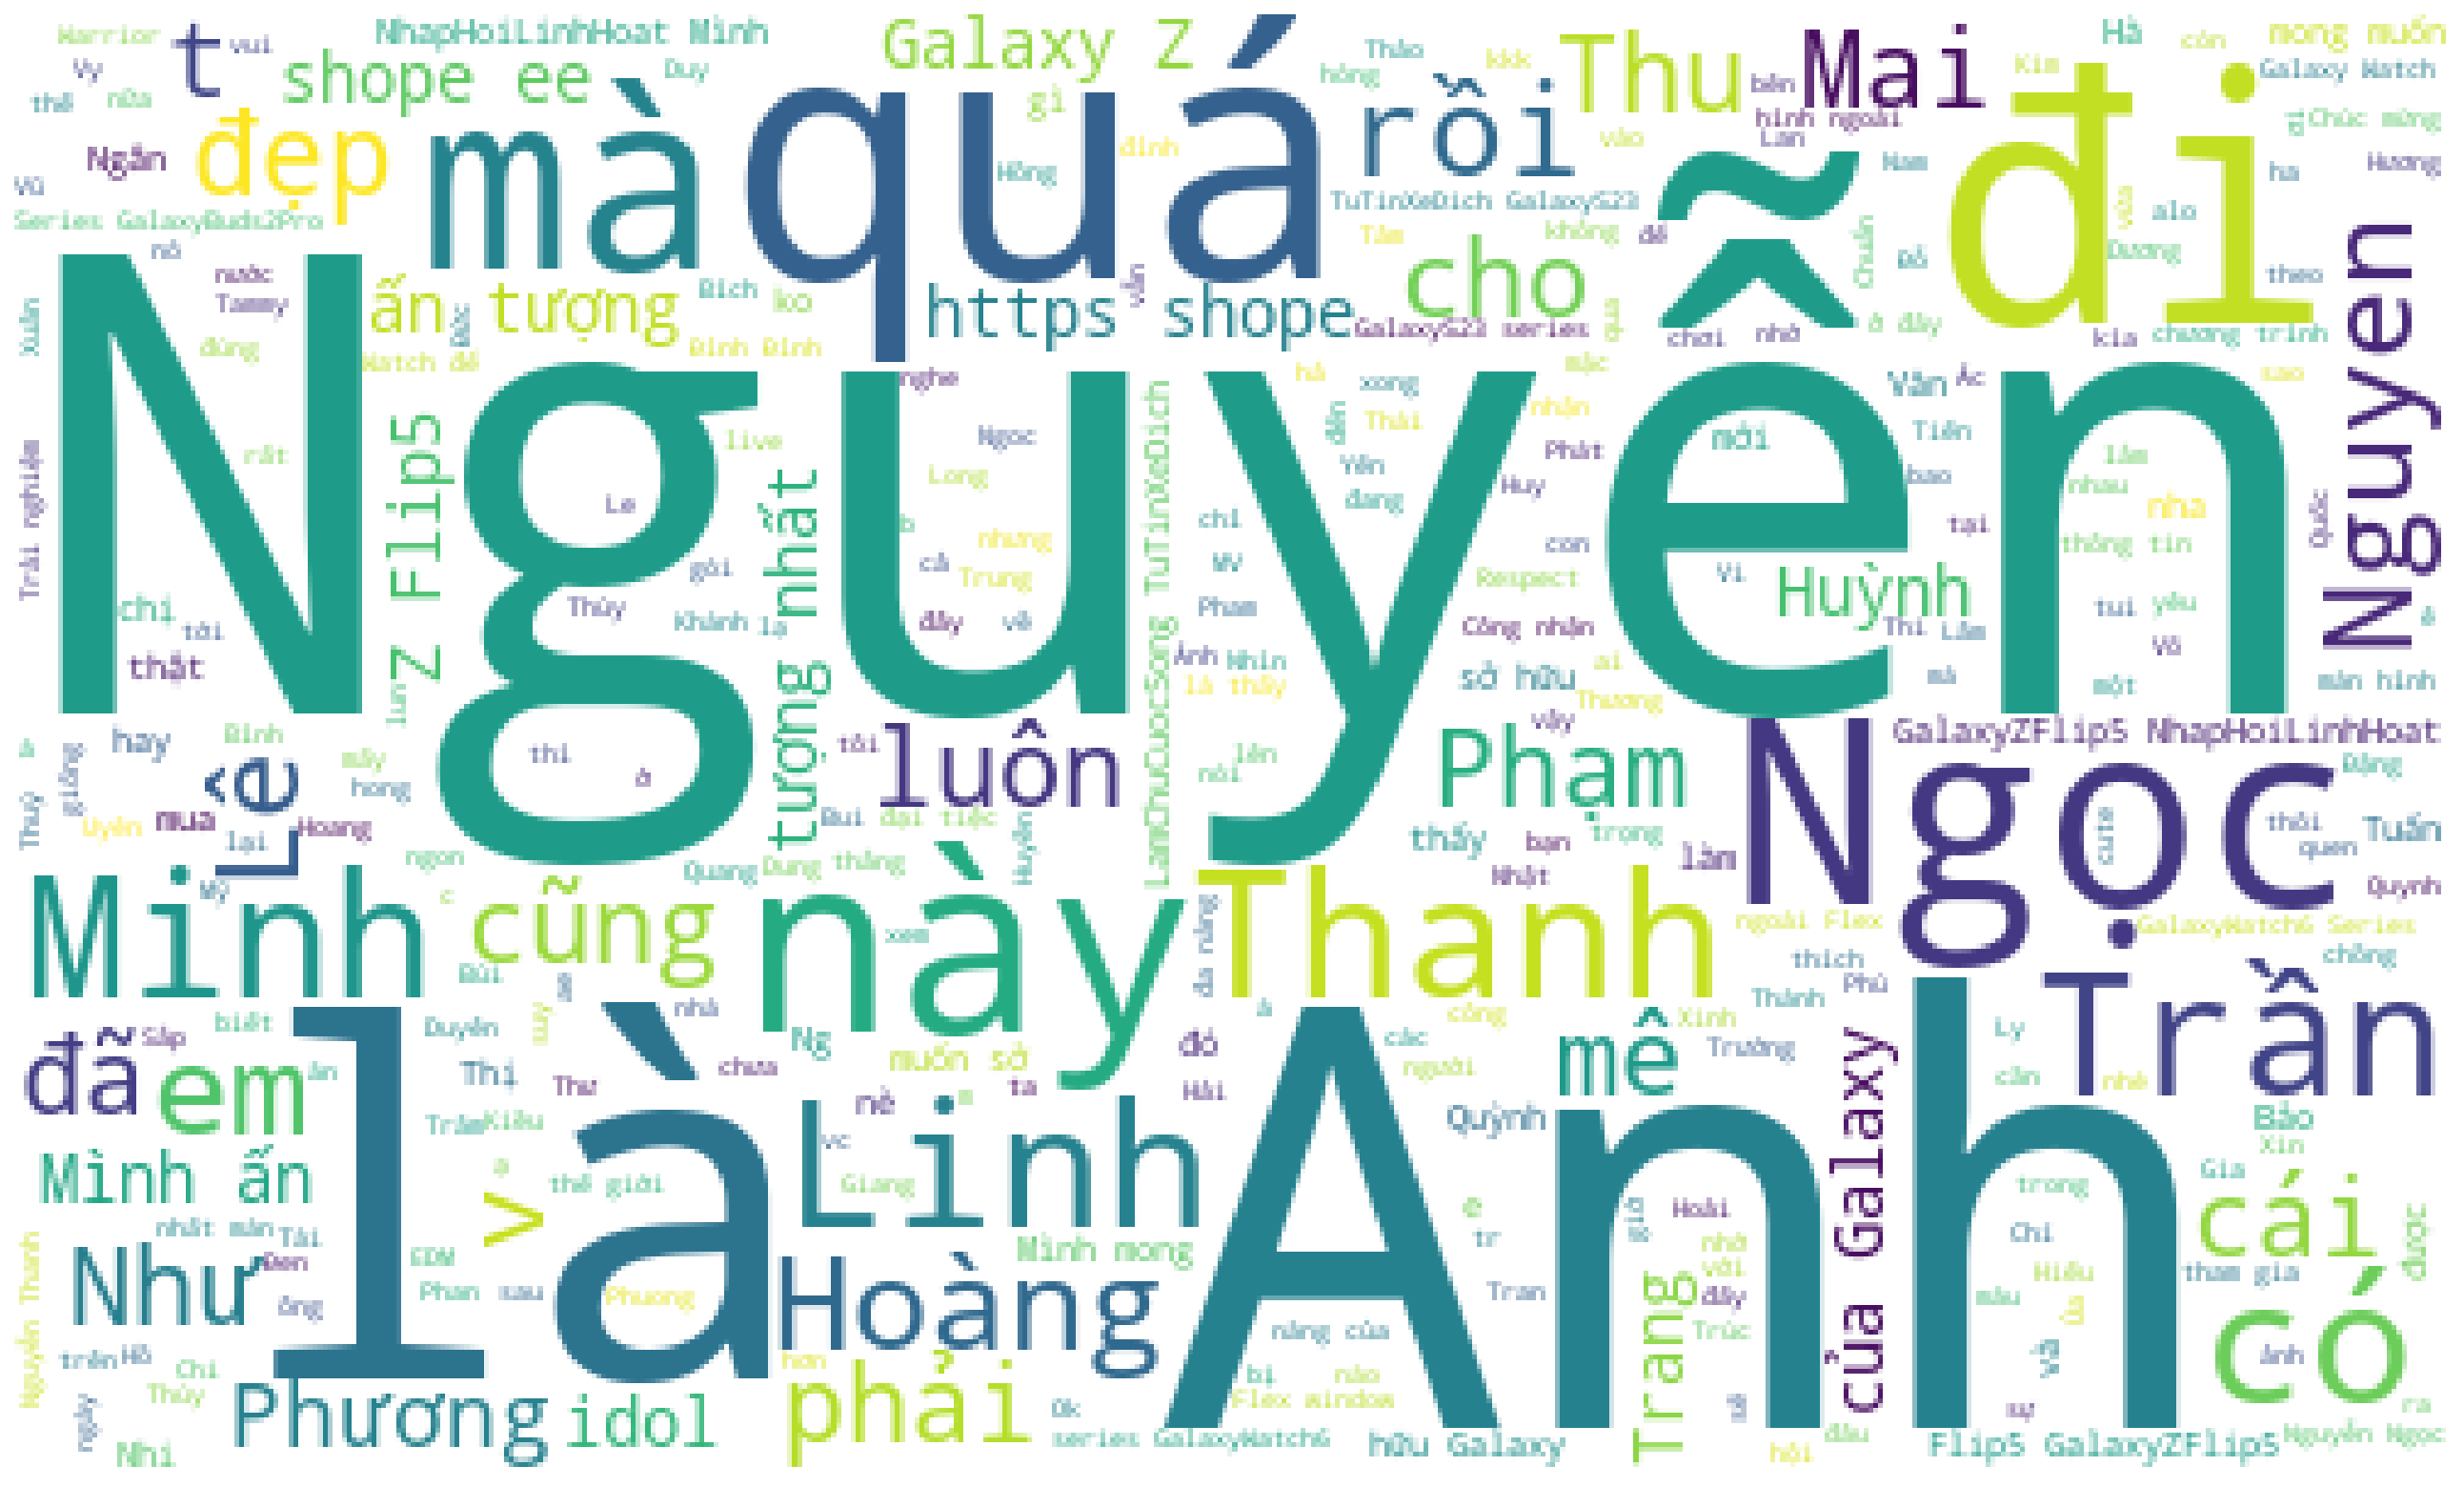

In [57]:
commento = comment

wordcloud = WordCloud(stopwords=STOPWORDS, 
                      background_color='white',
                      max_words=300,
                      width=500, height=300).generate(commento)

plt.figure(figsize=(40, 20))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Phân tích những đặc điểm của người theo dõi page
- Liệu người hay theo dõi page có đặc điểm gì giống nhau (lứa tuổi, giới tính)
- Thời gian hoạt động của người dùng (tối ưu hóa lượt tương tác của page khi người dùng hoạt động)
- Nguồn tiếp cận (cho biết họ biết đến page từ đâu: bạn bè, người thân,...)

In [58]:
Profile = pd.read_csv('../Data/Data_Profile1.csv')
Name_gender = Profile[['id', 'Name', 'Thông tin cơ bản']]
Name_gender

,id,Name,Thông tin cơ bản
0,100005000000000,Đặng Thùy Vân,Nữ\r\nGiới tính
1,100003000000000,Trần Long,Nam\r\nGiới tính
2,100050000000000,Văn Thiện,NaN
3,100000000000000,Linh Nguyen,Nữ\r\nGiới tính
4,100013000000000,Huyền,NaN
...,...,...,...
190,100048629986050,Trinh Trinh,"6 tháng 10, 2002\r\nNgày sinh"
191,100010990543917,Teresa Nguyễn,Nữ\r\nGiới tính
192,100086142787284,Ngoc Trang Tran,NaN
193,100047200622211,Như CH,29 tháng 9\r\nNgày sinh


In [59]:
Name_gender.dropna(axis=0)

,id,Name,Thông tin cơ bản
0,100005000000000,Đặng Thùy Vân,Nữ\r\nGiới tính
1,100003000000000,Trần Long,Nam\r\nGiới tính
3,100000000000000,Linh Nguyen,Nữ\r\nGiới tính
5,100017000000000,Việt Nguyễn,Nam\r\nGiới tính
6,100014000000000,Hoàng Đức Huy,10 tháng 12\r\nNgày sinh\r\nNam\r\nGiới tính
...,...,...,...
189,100004800557442,Quang Quang,Nam\r\nGiới tính
190,100048629986050,Trinh Trinh,"6 tháng 10, 2002\r\nNgày sinh"
191,100010990543917,Teresa Nguyễn,Nữ\r\nGiới tính
193,100047200622211,Như CH,29 tháng 9\r\nNgày sinh


<Axes: >

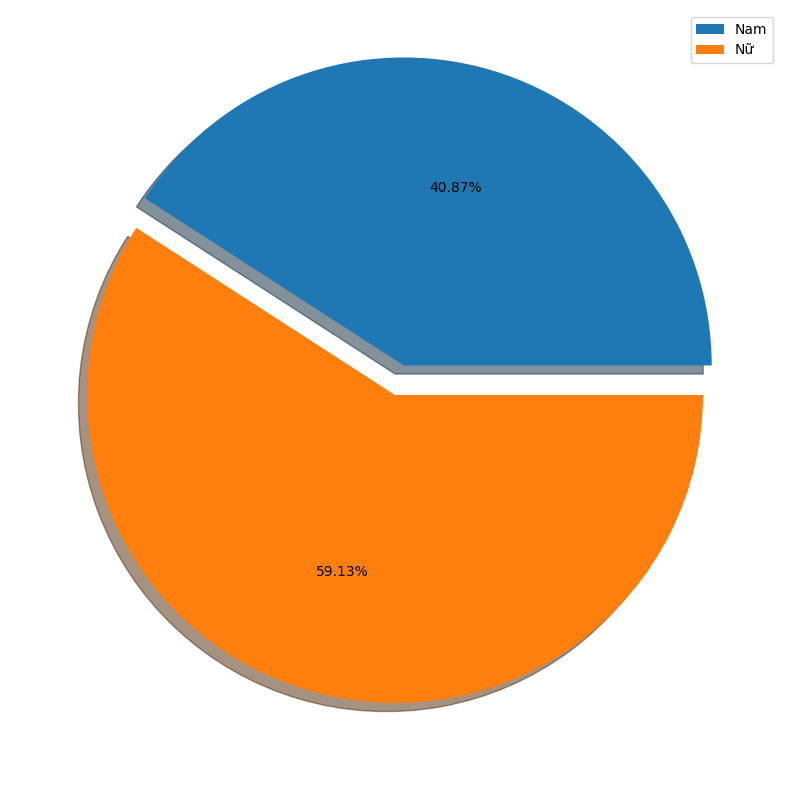

In [60]:
temp = {}
for i in Name_gender['Thông tin cơ bản']:
    s = str(i).split('\r\n')
    for j in range(len(s)):
        if s[j]=="Giới tính":
            if s[j-1] not in temp:
                temp[s[j-1]]=1
            else:
                temp[s[j-1]]+=1
Gioi_tinh = []
Gioi_tinh.append(temp)
Gioi_tinh = pd.DataFrame(columns=['Nam', 'Nữ'], data=Gioi_tinh)
Gioi_tinh.mean().plot(kind='pie', explode = [0.1, 0], labels = None, figsize=(10,10), shadow = True, legend=True, autopct='%1.2f%%')

In [61]:
Address = Profile[['id', 'Name', 'Nơi từng sống']]
Address.dropna()

,id,Name,Nơi từng sống
19,100014000000000,Diêm Diễm,Thành phố Hồ Chí Minh\r\nTỉnh/Thành phố hiện t...
20,100007000000000,Ngânn Pii,"Thủ Đức, Thành Phố Hồ Chí Minh\r\nĐã chuyển đế..."
22,100013000000000,Tất Thiên Thanh,Thành phố Hồ Chí Minh\r\nTỉnh/Thành phố hiện t...
24,100067000000000,Quỳnh Dương,Sơn La\r\nTỉnh/Thành phố hiện tại\r\nMộc Châu\...
25,100003000000000,Thuần Vũ,Hải Phòng\r\nTỉnh/Thành phố hiện tại\r\nHải Ph...
...,...,...,...
190,100048629986050,Trinh Trinh,Cà Mau\r\nTỉnh/Thành phố hiện tại\r\nCà Mau\r\...
191,100010990543917,Teresa Nguyễn,Hà Nội\r\nTỉnh/Thành phố hiện tại\r\nHà Nội\r\...
192,100086142787284,Ngoc Trang Tran,Hà Nội\r\nTỉnh/Thành phố hiện tại
193,100047200622211,Như CH,Thành phố Hồ Chí Minh\r\nTỉnh/Thành phố hiện tại


In [62]:
temps = {}
tinh = ['An Giang','Bà Rịa - Vũng Tàu','Bạc Liêu','Bắc Giang','Bắc Kạn','Bắc Ninh',
        'Bến Tre','Bình Dương','Bình Định','Bình Phước','Bình Thuận','Cà Mau','Cao Bằng',
        'Cần Thơ','Đà Nẵng','Đắk Lắk','Đắk Nông','Điện Biên','Đồng Nai','Đồng Tháp',
        'Gia Lai','Hà Giang','Hà Nam','Hà Nội','Hà Tĩnh','Hải Dương','Hải Phòng',
        'Hậu Giang','Hòa Bình','Thành phố Hồ Chí Minh','Hưng Yên','Khánh Hòa','Kiên Giang',
        'Kon Tum','Lai Châu','Lạng Sơn','Lào Cai','Lâm Đồng','Long An','Nam Định',
        'Nghệ An','Ninh Bình','Ninh Thuận','Phú Thọ','Phú Yên','Quảng Bình','Quảng Nam',
        'Quảng Ngãi','Quảng Ninh','Quảng Trị','Sóc Trăng','Sơn La','Tây Ninh','Thái Bình',
        'Thái Nguyên','Thanh Hóa','Thừa Thiên Huế','Tiền Giang','Trà Vinh','Tuyên Quang',
        'Vĩnh Long','Vĩnh Phúc','Yên Bái']
bac = []
trung = []
nam = []
word = ''
for i in tinh:
    if i not in temps:
        temps[i]=0
for i in Address['Nơi từng sống']:
    for j in tinh:
        if j in str(i):
            temps[j]+=1
            word=word+j+' '
Dia_chi = []
Dia_chi.append(temps)
Dia_chi = pd.DataFrame(Dia_chi)
Dia_chi

,An Giang,Bà Rịa - Vũng Tàu,Bạc Liêu,Bắc Giang,Bắc Kạn,Bắc Ninh,Bến Tre,Bình Dương,Bình Định,Bình Phước,...,Thái Bình,Thái Nguyên,Thanh Hóa,Thừa Thiên Huế,Tiền Giang,Trà Vinh,Tuyên Quang,Vĩnh Long,Vĩnh Phúc,Yên Bái
0,3,0,1,2,1,1,5,0,0,0,...,1,1,1,0,0,3,0,2,0,1


<Axes: >

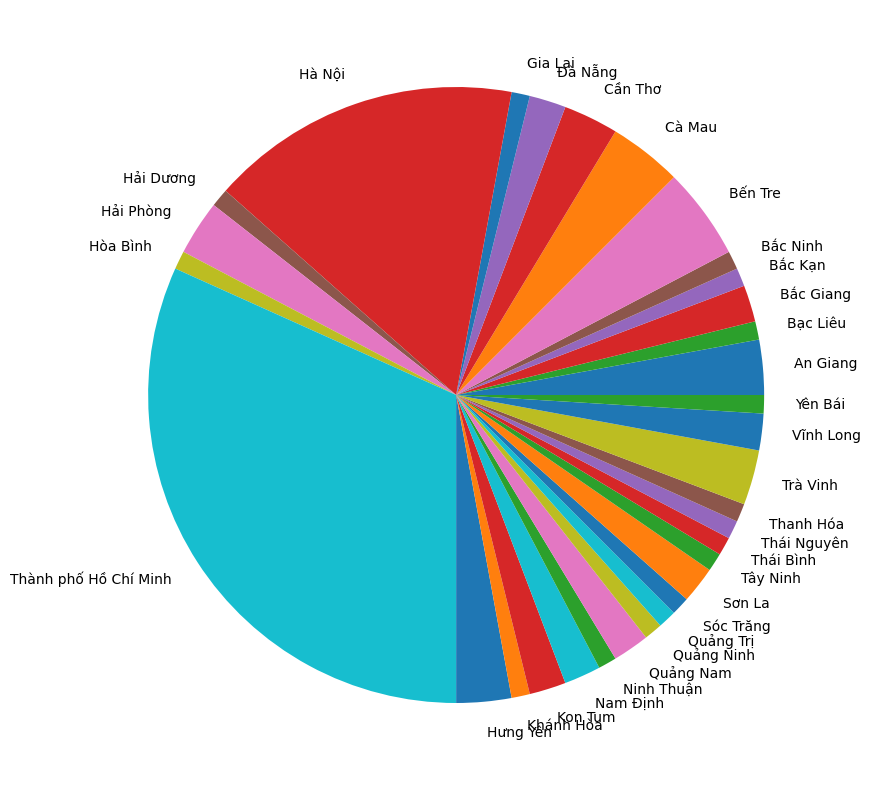

In [63]:
Dia_chi.mean().plot(kind='pie', figsize=(10,10))

<Axes: >

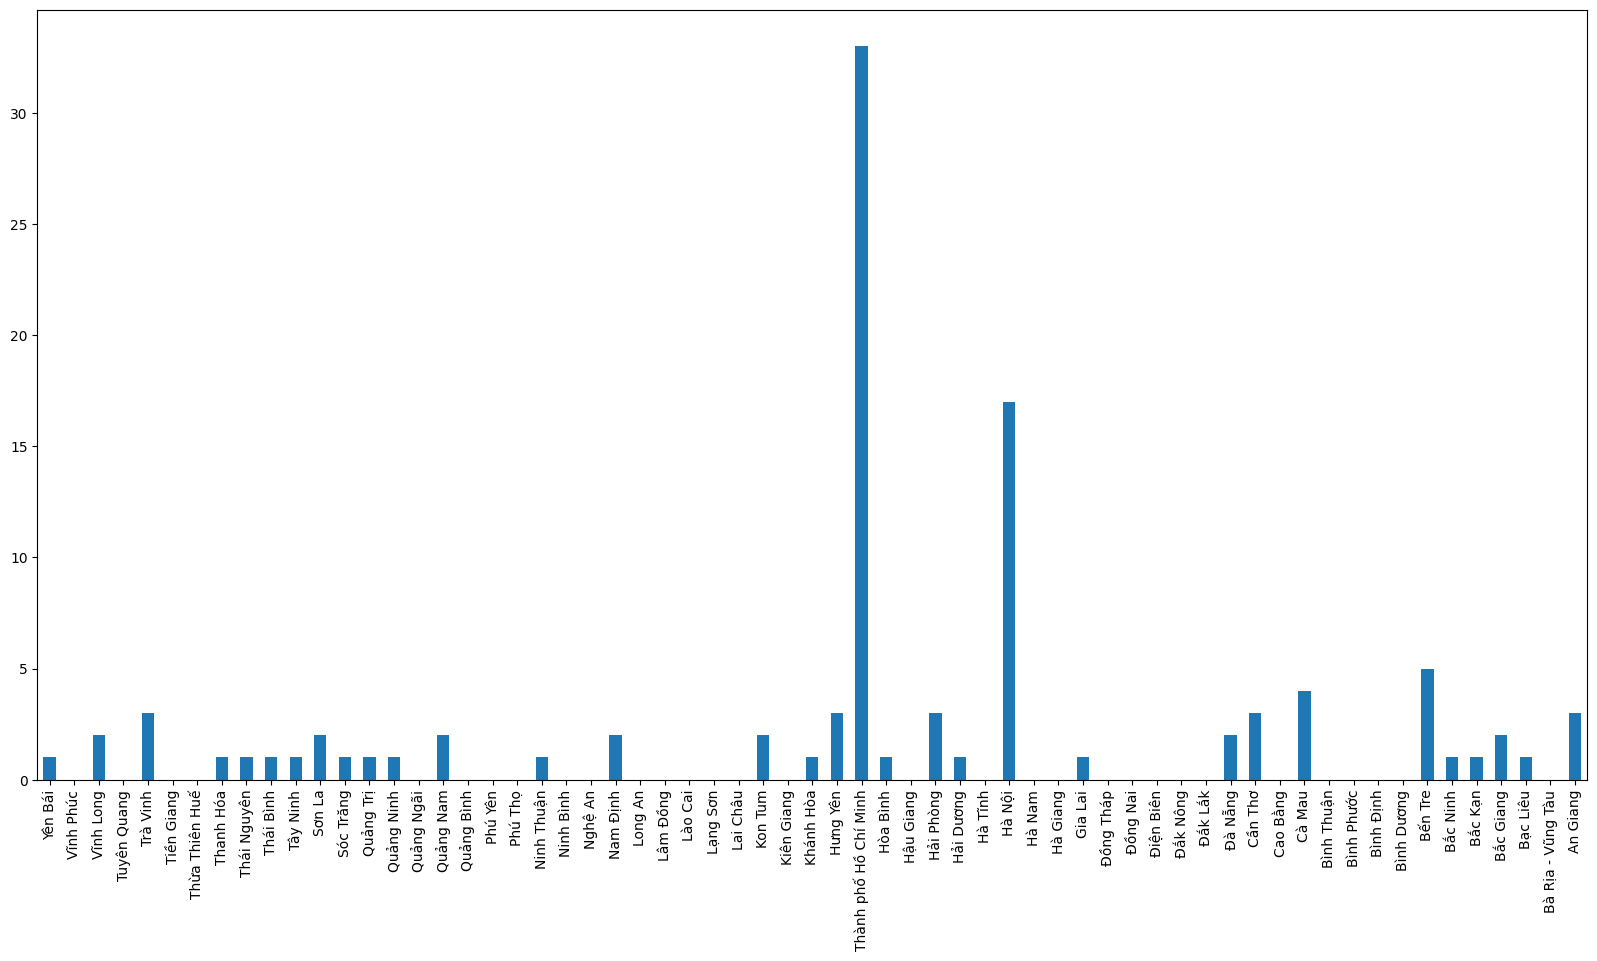

In [73]:
a = Dia_chi.loc[0].index[::]
b = a[::-1]
x = Dia_chi.loc[:,b]
x = x.loc[0]
x.plot(kind = 'bar', figsize=(20,10))
